In [1]:
# Make plots interactive in the notebook
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np

import os
import sys

# Add QDYN source directory to PATH
# Go up in the directory tree
upup = [os.pardir]*2
qdyn_dir = os.path.join(*upup)
# Get QDYN src directory
src_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "src")
)
# Append src directory to Python path
sys.path.append(src_dir)
# Get QDYN plotting library directory
plot_dir = os.path.abspath(
    os.path.join(
        os.path.join(os.path.abspath(""), qdyn_dir), "utils", "post_processing")
)
# Append plotting library directory to Python path
sys.path.append(plot_dir)

# Import QDYN wrapper and plotting library
from pyqdyn import qdyn
import plot_functions as qdyn_plot

In [273]:
# Instantiate the QDYN class object
p = qdyn()

# Predefine parameters
t_yr = 3600 * 24 * 365.0    # seconds per year
Lasp = 10                   # Length of fault / nucleation length
ab_ratio = 0.8              # a/b of fault
cab_ratio = 1 - ab_ratio
resolution = 7              # Mesh resolution / process zone width

# Get the settings dict
set_dict = p.set_dict


""" Damage zone settings """

D = 0.5     # Damage level = 1 - (damaged shear mod.) / (intact shear mod.)
HD = 10.    # Half-thickness of damage zone [m]

# Set HD to zero if D is zero, otherwise you simulate a finite slab
if D == 0:
    HD = 0
set_dict["D"] = D
set_dict["HD"] = HD


""" Simulation/mesh parameters """

# Global simulation parameters
set_dict["MESHDIM"] = 1        # Simulation dimensionality (1D fault in 2D medium)
set_dict["FINITE"] = 0         # Periodic fault
set_dict["TMAX"] = 50*t_yr     # Maximum simulation time [s]
set_dict["NTOUT"] = 10         # Save snapshots every N steps
set_dict["NXOUT"] = 2          # Snapshot resolution (every N elements)
set_dict["V_PL"] = 1e-9        # Plate velocity
set_dict["MU"] = 3e10          # Shear modulus
set_dict["W"] = 10e3           # Loading distance [m]
set_dict["SIGMA"] = 1e8        # Effective normal stress [Pa]
set_dict["ACC"] = 1e-7         # Solver accuracy
set_dict["SOLVER"] = 2         # Solver type (Runge-Kutta)


""" RSF parameters """

set_dict["SET_DICT_RSF"]["A"] = 1.0e-2    # Direct effect
set_dict["SET_DICT_RSF"]["B"] = set_dict["SET_DICT_RSF"]["A"] / ab_ratio      # Evolution effect
set_dict["SET_DICT_RSF"]["DC"] = 4e-4     # Characteristic slip distance
set_dict["SET_DICT_RSF"]["V_SS"] = set_dict["V_PL"]    # Reference velocity [m/s]
set_dict["SET_DICT_RSF"]["V_0"] = 0.5 * set_dict["V_PL"]    # Initial velocity [m/s]
set_dict["SET_DICT_RSF"]["TH_0"] = set_dict["SET_DICT_RSF"]["DC"] / set_dict["V_PL"]    # Initial state [s]

# Compute relevant length scales:
# Process zone width [m] (computed w.r.t. damage zone modulus)
Lb = set_dict["MU"] * set_dict["SET_DICT_RSF"]["DC"] / (set_dict["SET_DICT_RSF"]["B"] * set_dict["SIGMA"])
if D > 0:
    Lb *= D

# Nucleation length [m]
Lc = Lb / cab_ratio
# Length of fault [m]
L = Lasp * Lc

# Find next power of two for number of mesh elements
N = int(np.power(2, np.ceil(np.log2(resolution * L / Lb))))
# Spatial coordinate for mesh
x = np.linspace(-L/2, L/2, N, dtype=float)
# Mesh size
dx = np.abs(x[1] - x[0])

# Set mesh size and fault length
set_dict["N"] = N
set_dict["L"] = L
# Set time series output node to the middle of the fault
set_dict["IC"] = N // 2


""" Fluid injection parameters """

set_dict["FEAT_INJECTION"] = 1                     # Turn on fluid injection
set_dict["SET_DICT_INJECTION"]["SOURCE"] = 1       # 0: constant volume; 1: constant rate
set_dict["SET_DICT_INJECTION"]["C"] = 1.0e-1       # Source amplitude
set_dict["SET_DICT_INJECTION"]["K"] = 1e-6         # Fault diffusivity [m2/s]

dt = (5 * dx)**2 / (4 * set_dict["SET_DICT_INJECTION"]["K"])
set_dict["SET_DICT_INJECTION"]["T0"] = -dt         # Start time of fluid source (relative to start simulation)



""" Set parameter values and generate mesh """
p.settings(set_dict)
p.render_mesh()

print(f"Fault length: {L:.2f} m")
print(f"No. of elements: {N}")
print(f"Mesh size: {dx:.2f} m")

# Write input to qdyn.in
p.write_input()

Fault length: 240.00 m
No. of elements: 512
Mesh size: 0.47 m


True

In [274]:
p.run()

0

In [275]:
p.read_output()

True

<IPython.core.display.Javascript object>


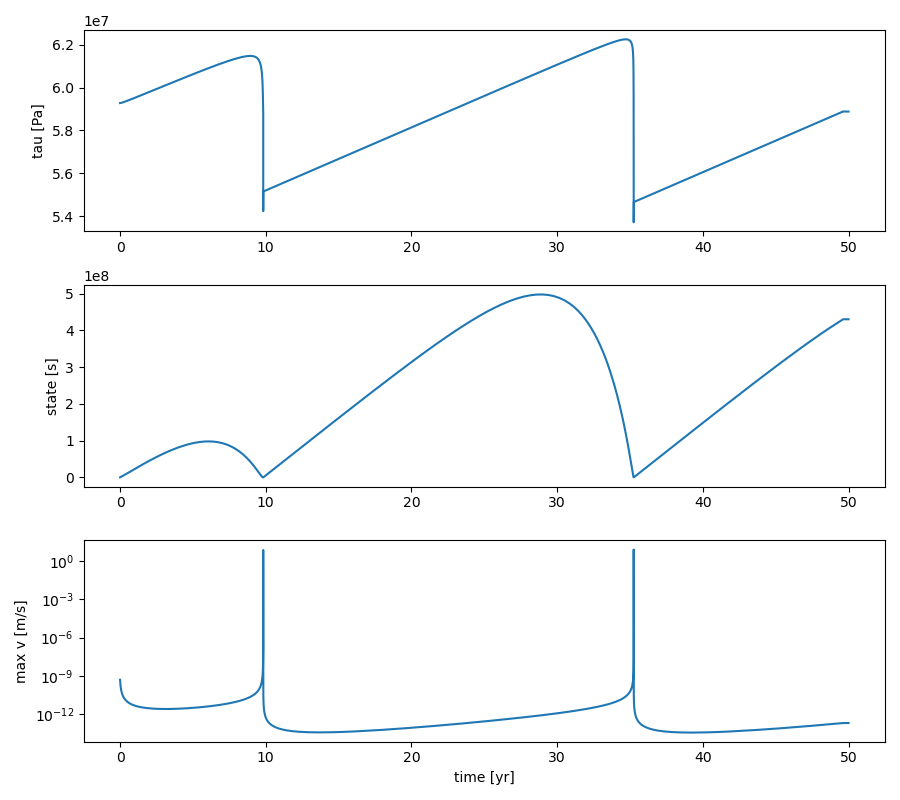

In [276]:
# Time series of stress, state, and maximum slip rate on the fault
qdyn_plot.timeseries(p.ot[0], p.ot_vmax)

<IPython.core.display.Javascript object>


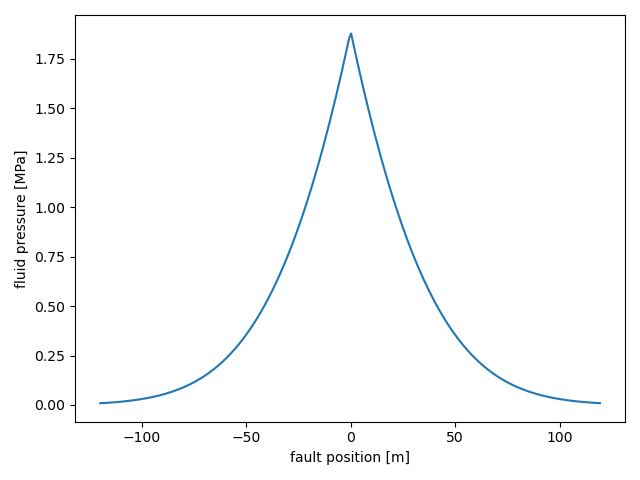

In [278]:
# Get profile of fluid pressure at last time step
t_ox = p.ox["t"].unique() - 1
x_ox = p.ox["x"].unique()
Nt, Nx = len(t_ox), len(x_ox)
P = np.array(p.ox["P"][:Nt * Nx]).reshape((Nt, Nx))

plt.close("all")
plt.figure()
plt.plot(x_ox, P[-1] * 1e-6)
plt.xlabel("fault position [m]")
plt.ylabel("fluid pressure [MPa]")
plt.tight_layout()
plt.show()

# Verification of results

<IPython.core.display.Javascript object>


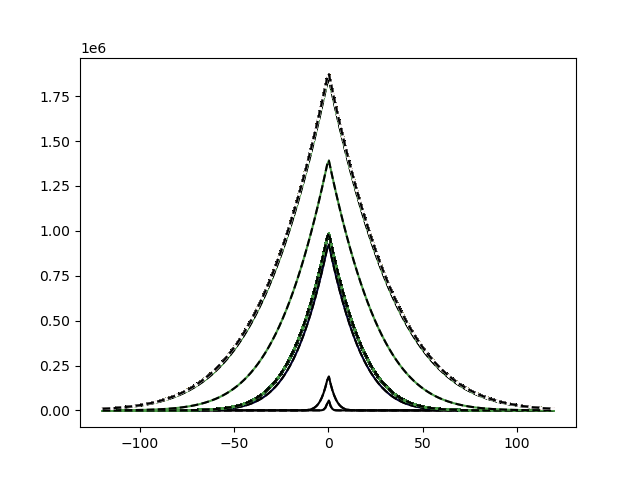

In [280]:
def const_vol(x, t):
    alpha = np.sqrt(4 * set_dict["SET_DICT_INJECTION"]["K"] * (t - set_dict["SET_DICT_INJECTION"]["T0"]))
    x_alpha = ((x - set_dict["SET_DICT_INJECTION"]["X0"]) / alpha)**2
    x_alpha = np.minimum(x_alpha, 90.0)
    P = set_dict["SET_DICT_INJECTION"]["C"] * np.exp(-x_alpha) / alpha / np.sqrt(np.pi)
    return P

def const_rate(x, t):
    from scipy.special import erfc
    alpha = np.sqrt(4 * set_dict["SET_DICT_INJECTION"]["K"] * (t - set_dict["SET_DICT_INJECTION"]["T0"]))
    x_alpha = np.abs(x - set_dict["SET_DICT_INJECTION"]["X0"]) / alpha
    exp_term = np.exp(-x_alpha**2) - np.sqrt(np.pi) * x_alpha * erfc(x_alpha)
    A = alpha / set_dict["SET_DICT_INJECTION"]["K"] * exp_term
    P = set_dict["SET_DICT_INJECTION"]["C"] * 0.5 * 1/np.sqrt(np.pi) * A
    return P

import seaborn

skip = 4
N_P = len(t_ox) // skip
colours = seaborn.color_palette("gist_earth", N_P)

plt.close("all")
plt.figure()
for i, c in enumerate(colours):
    plt.plot(x_ox, P[i * skip], c=c)
    if set_dict["SET_DICT_INJECTION"]["SOURCE"] == 0:
        plt.plot(x_ox, const_vol(x_ox, t_ox[i * skip]), "k--")
    else:
        plt.plot(x_ox, const_rate(x_ox, t_ox[i * skip]), "k--")
plt.show()